In [2]:
import pandas as pd
from sciviso import *
from sciutil import SciUtil
import numpy as np
import seaborn as sns
# Have a look at clustering each of these
from sklearn.decomposition import PCA

u = SciUtil()

cpg_sample_df = pd.read_csv('cpg_sample_df.csv')
meth_df = pd.read_csv('../../output_data/DNAMethylation.csv')
cols = list(cpg_sample_df['Sample'].values)

meth_df = meth_df.replace(0, 0.001)
meth_df = meth_df.replace(1.0, 0.999)

mean_meth = np.nanmean(meth_df[cols].values, axis=1)
u.dp(['Methylation size: ', meth_df.shape, 'Mean meth:', mean_meth])

meth_df = meth_df[mean_meth > 0.05]

u.dp(['Methylation size after 0.05 filter: ', meth_df.shape, 'Mean meth:', mean_meth])

mean_meth = np.nanmean(meth_df[cols].values, axis=1)
meth_df = meth_df[mean_meth < 0.95]

u.dp(['Methylation size after 0.95 filter: ', meth_df.shape, 'Mean meth:', mean_meth])

corr = meth_df[cols].corr()
# Print out the minimum correlation:
mean_cor = np.nanmean(corr, axis=1)
corr['mean_corr'] = mean_cor
corr.sort_values(by=['mean_corr'])


/var/folders/gq/6ljhmvm1713fykdjqbl188pm0000gn/T/ipykernel_5934/1285995814.py:18: RuntimeWarning: Mean of empty slice
  mean_meth = np.nanmean(meth_df[cols].values, axis=1)


--------------------------------------------------------------------------------
Methylation size: 	(865918, 949)	Mean meth:	[0.01782784 0.86310826 0.15392915 ... 0.70328099 0.1028839  0.69170137]	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Methylation size after 0.05 filter: 	(688614, 949)	Mean meth:	[0.01782784 0.86310826 0.15392915 ... 0.70328099 0.1028839  0.69170137]	
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
Methylation size after 0.95 filter: 	(672074, 949)	Mean meth:	[0.86310826 0.15392915 0.12531187 ... 0.70328099 0.1028839  0.69170137]	
--------------------------------------------------------------------------------


,C3N.01946_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_e8ecbb0b.6130.4758.aac0.f54284c73531,C3N.01754_Normal_CpG_HeadandNeckSquamousCellCarcinoma_bfbdfd0c.7ae4.4b8c.8d8a.69322f91517a,C3L.01138_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_d5827d06.3510.4ec4.ae59.01abf740fcd9,C3L.01138_Normal_CpG_HeadandNeckSquamousCellCarcinoma_1988b87e.95bc.40dd.af21.289612a40538,C3N.03888_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_5fd18655.4df4.4a7f.abd1.f9fd046878d9,C3N.03888_Normal_CpG_HeadandNeckSquamousCellCarcinoma_e0a21d76.a109.421c.ad52.0bb6562856d8,C3N.04280_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_d08052ab.6738.424e.8727.e75fdb1734ee,C3N.01945_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_3af51c2d.0e64.473f.abb0.12752a681749,C3L.04791_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_264bc89e.13a8.4e1d.8751.6ba8538cc942,C3N.00822_Tumor_CpG_HeadandNeckSquamousCellCarcinoma_4b45afdf.ea9a.45af.970b.9a4daa1b4bbd,...,C3N.02424_Normal_CpG_LungAdenocarcinoma_2bc703ee.6743.4daf.8341.ede838026439,C3N.02433_Normal_CpG_LungAdenocarcinoma_fa58dd7c.2803.48ed.a9e4.9d834a081d9a,C3N.02529_Normal_CpG_LungAdenocarcinoma_671c9595.5b73.4774.811a.4330bb30db4e,C3N.02572_Normal_CpG_LungAdenocarcinoma_aab7e3d5.db24.4fb3.8f4e.4cd9f3dee6eb,C3N.02582_Normal_CpG_LungAdenocarcinoma_02b912b4.bd9c.44a8.bc85.0f68cc06954d,C3N.02586_Normal_CpG_LungAdenocarcinoma_d4ed0734.bd0f.4f36.904b.21f0c474ab84,C3N.02587_Normal_CpG_LungAdenocarcinoma_36dec540.8704.4552.a867.9606dcaa652b,C3N.02588_Normal_CpG_LungAdenocarcinoma_496143de.98f0.44d8.8a54.9a1eac8eaa4d,C3N.02729_Normal_CpG_LungAdenocarcinoma_fc4ebcaa.b8cd.4e23.be3d.879372c092c8,mean_corr
C3N.01719_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d97c51cd.deac.42a6.9fdf.3941fe370ecc,-0.066719,-0.082925,-0.066530,-0.079481,-0.068316,-0.081688,-0.047805,-0.073086,-0.077180,-0.056407,...,-0.072776,-0.077869,-0.074988,-0.078982,-0.063398,-0.080118,-0.073445,-0.077180,-0.070180,-0.056249
C3N.00388_Tumor_CpG_UterineCorpusEndometrialCarcinoma_7cd78ad0.fd44.4bf1.8700.e4cf732fa1b6,-0.049105,-0.057498,-0.050734,-0.055096,-0.046781,-0.057132,-0.036009,-0.058902,-0.053734,-0.045649,...,-0.053029,-0.056289,-0.054408,-0.057471,-0.051694,-0.058156,-0.055086,-0.057593,-0.055042,-0.047367
C3N.03426_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d09f9fcc.2b8b.436a.8ffd.9d7455c9b1ab,-0.024886,-0.037012,-0.027455,-0.030581,-0.023744,-0.034030,-0.017931,-0.031151,-0.030512,-0.020069,...,-0.031664,-0.033005,-0.031841,-0.035358,-0.030068,-0.035237,-0.034181,-0.036310,-0.033942,-0.026246
C3N.02971_Tumor_CpG_PancreaticDuctalAdenocarcinoma_977dd7b9.cfb7.42f2.b554.e43c23b9f3e9,-0.023305,-0.033414,-0.026426,-0.030718,-0.020591,-0.032661,-0.015815,-0.031951,-0.028048,-0.023004,...,-0.030768,-0.033507,-0.032497,-0.033264,-0.029832,-0.033657,-0.032773,-0.033671,-0.032764,-0.025244
C3N.04283_Tumor_CpG_PancreaticDuctalAdenocarcinoma_de177c77.a468.4813.bea8.d9dcfc71756e,-0.007447,-0.008425,-0.007080,-0.009176,-0.007708,-0.008566,-0.006920,-0.009565,-0.008607,-0.005515,...,-0.007696,-0.008118,-0.006293,-0.007958,-0.005655,-0.007958,-0.007172,-0.007613,-0.009693,-0.006654
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C3N.01194_Normal_CpG_LungSquamousCellCarcinoma_ba10c539.41e7.43c0.92dc.6035cecf2c3b,0.914836,0.940071,0.889179,0.969954,0.882715,0.944527,0.804829,0.957022,0.946120,0.891692,...,0.991830,0.981707,0.985599,0.983446,0.976563,0.991406,0.980139,0.986019,0.988476,0.889467
C3L.02552_Normal_CpG_LungSquamousCellCarcinoma_d00b5c02.ff28.4822.8128.cdc4e0fe7db4,0.908425,0.947438,0.888943,0.966060,0.880363,0.951052,0.806860,0.955756,0.944337,0.889260,...,0.989546,0.981764,0.983866,0.983163,0.978304,0.989206,0.980571,0.985030,0.987673,0.889571
C3N.02424_Normal_CpG_LungAdenocarcinoma_2bc703ee.6743.4daf.8341.ede838026439,0.917763,0.936942,0.890036,0.970344,0.887159,0.942145,0.811062,0.956085,0.946526,0.892992,...,1.000000,0.981122,0.985840,0.983520,0.978669,0.990659,0.980129,0.985595,0.988639,0.889890
C3N.03424_Normal_CpG_LungSquamousCellCarc

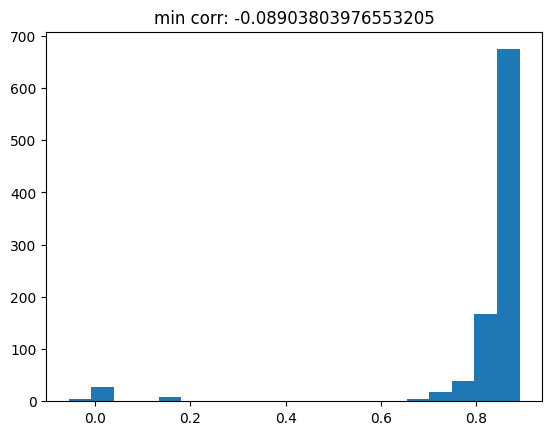

--------------------------------------------------------------------------------
                         Methylation columns to omit: 	                         
--------------------------------------------------------------------------------
C3N.01719_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d97c51cd.deac.42a6.9fdf.3941fe370ecc
C3N.00388_Tumor_CpG_UterineCorpusEndometrialCarcinoma_7cd78ad0.fd44.4bf1.8700.e4cf732fa1b6
C3N.03426_Tumor_CpG_PancreaticDuctalAdenocarcinoma_d09f9fcc.2b8b.436a.8ffd.9d7455c9b1ab
C3N.02971_Tumor_CpG_PancreaticDuctalAdenocarcinoma_977dd7b9.cfb7.42f2.b554.e43c23b9f3e9
C3N.04283_Tumor_CpG_PancreaticDuctalAdenocarcinoma_de177c77.a468.4813.bea8.d9dcfc71756e
C3N.03039_Tumor_CpG_PancreaticDuctalAdenocarcinoma_c99d1277.232f.429b.a454.60ad604d4e34
C3L.00913_Normal_CpG_LungAdenocarcinoma_5ff19da1.fba3.413f.9313.98b16729f3f0
C3N.03439_Tumor_CpG_PancreaticDuctalAdenocarcinoma_8b590f21.dca8.40f4.adc8.790892f151ee
C3N.03884_Tumor_CpG_PancreaticDuctalAdenocarcinoma_0965e7fc.4

In [5]:
import matplotlib.pyplot as plt
# Plot out the mean correlation values so we can choose a good filter.
plt.hist(mean_cor, bins=20)
plt.title(f'min corr: {np.min(corr)}')
plt.show()


# Filter the shitty patients
corr_sorted = corr.sort_values(by=['mean_corr'])
corr_sorted = corr_sorted[corr_sorted['mean_corr'] < 0.7]
cols_to_omit = [c for c in corr_sorted.index]

u.dp(['Methylation columns to omit: '])

print('\n'.join(cols_to_omit))
cols_to_keep = [c for c in meth_df.columns if c not in cols_to_omit]
cpg_filtered = meth_df[cols_to_keep]

u.dp(['New size:', cpg_filtered.shape])

In [6]:


# Drop CpGs with > 50% missing values
cpg_filtered = cpg_filtered[cpg_filtered.isnull().sum(axis=1) < len(cpg_filtered.values[0])/2]

u.dp(['After dropping rows with 50% nulls:', cpg_filtered.shape])

# Filter sample df to only include those samples
sample_df = cpg_sample_df[cpg_sample_df['Sample'].isin(cols_to_keep)]


# Fill NAs with 0's
df = cpg_filtered.fillna(0.001)



--------------------------------------------------------------------------------
               After dropping rows with 50% nulls:	(631877, 900)	               
--------------------------------------------------------------------------------


# Visualisations 

In [7]:

cols = list(sample_df['Sample'].values)
vals = df[cols].values.T

pca = PCA(n_components=2)
pca_values = pca.fit_transform(vals)

var_ratio = pca.fit(vals).explained_variance_ratio_

plt.rcParams['figure.figsize'] = [4, 4]

vis_df = pd.DataFrame()
vis_df['PC_1'] = pca_values[:, 0]
vis_df['PC_2'] = pca_values[:, 1]
vis_df['Stage'] = sample_df['TumorStage_x'].values
vis_df['Disease'] = sample_df['Disease'].values
vis_df['CondID'] = sample_df['CondID'].values


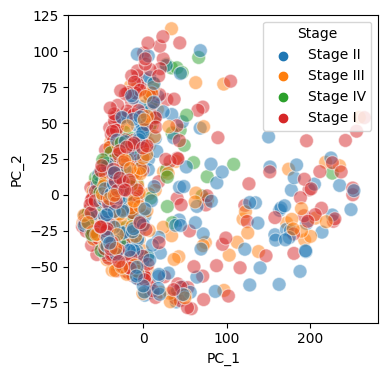

In [8]:
sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='Stage', s=100, alpha=0.5)
plt.show()

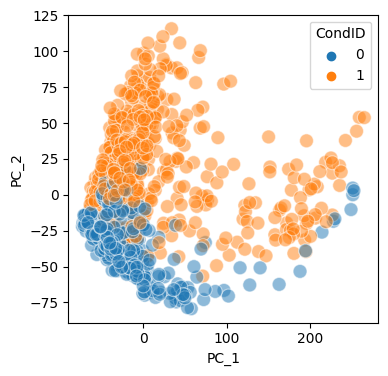

In [9]:

sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='CondID', s=100, alpha=0.5)
plt.show()

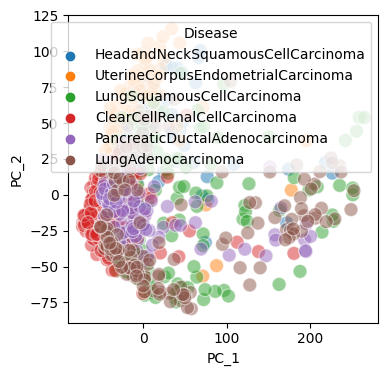

In [10]:

sns.scatterplot(vis_df, x='PC_1', y='PC_2', hue='Disease', s=100, alpha=0.5)
plt.show()

# For ccRCC we want only the ccRCC and then everything else!

In [11]:
# Drop duplicates based on the case ID and the condition type
u.dp([sample_df.shape])
sample_df_dedup = sample_df.drop_duplicates(subset=['SafeCases', 'CondID'])
u.dp([sample_df_dedup.shape])

--------------------------------------------------------------------------------
                                  (898, 634)	                                   
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
                                  (806, 634)	                                   
--------------------------------------------------------------------------------


In [15]:
sample_df_dedup[sample_df_dedup['Sample'].isin(ccrcc_samples)]

,SafeCases,Sample,TumorStage_x,Stage_x,AgeYears_x,CaseFiles_x,CaseFileCounts_x,Case ID_x,Cases Submitter ID_x,Related Entities_x,...,treatment_dose_y,treatment_dose_units_y,treatment_effect_y,treatment_effect_indicator_y,treatment_frequency_y,treatment_intent_type_y,treatment_or_therapy_y,treatment_outcome_y,treatment_type_y,Disease
384,C3L.00791,C3L.00791_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage III,Late,-76.0,C3L.00791_Tumor_RNA_ClearCellRenalCellCarcinom...,2,dae8930e-1fb8-11e9-b7f8-0a80fada099c,C3L-00791,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
385,C3L.00360,C3L.00360_Normal_CpG_ClearCellRenalCellCarcino...,Stage II,Early,-72.0,C3L.00360_Tumor_RNA_ClearCellRenalCellCarcinom...,4,bf7ade95-1fb8-11e9-b7f8-0a80fada099c,C3L-00360,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
386,C3L.00360,C3L.00360_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage II,Early,-72.0,C3L.00360_Tumor_RNA_ClearCellRenalCellCarcinom...,4,bf7ade95-1fb8-11e9-b7f8-0a80fada099c,C3L-00360,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
387,C3L.00097,C3L.00097_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage I,Early,-59.0,C3L.00097_Normal_RNA_ClearCellRenalCellCarcino...,3,b76d3749-1fb8-11e9-b7f8-0a80fada099c,C3L-00097,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
388,C3L.00583,C3L.00583_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage I,Early,-55.0,C3L.00583_Tumor_RNA_ClearCellRenalCellCarcinom...,8,cc8a63fd-1fb8-11e9-b7f8-0a80fada099c,C3L-00583,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
634,C3L.00103,C3L.00103_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage III,Late,-56.0,C3L.00103_Tumor_RNA_ClearCellRenalCellCarcinom...,8,b9017fed-1fb8-11e9-b7f8-0a80fada099c,C3L-00103,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
635,C3L.00103,C3L.00103_Normal_CpG_ClearCellRenalCellCarcino...,Stage III,Late,-56.0,C3L.00103_Tumor_RNA_ClearCellRenalCellCarcinom...,8,b9017fed-1fb8-11e9-b7f8-0a80fada099c,C3L-00103,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
638,C3L.00817,C3L.00817_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage I,Early,-80.0,C3L.00817_Tumor_RNA_ClearCellRenalCellCarcinom...,2,e9ac28c9-1fb8-11e9-b7f8-0a80fada099c,C3L-00817,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma
639,C3L.01557,C3L.01557_Tumor_CpG_ClearCellRenalCellCarcinom...,Stage III,Late,-51.0,C3L.01557_Tumor_RNA_ClearCellRenalCellCarcinom...,2,20e173fc-1fb9-11e9-b7f8-0a80fada099c,C3L-01557,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,ClearCellRenalCellCarcinoma


In [14]:
ccrcc_samples = list(sample_df_dedup[sample_df_dedup['Disease'] == 'ClearCellRenalCellCarcinoma']['Sample'].values)
sample_df_dedup[sample_df_dedup['Sample'].isin(ccrcc_samples)].to_csv('../../output_data/ccrcc_filtered_samples_CpG.csv', index=False)
sample_df_dedup[~sample_df_dedup['Sample'].isin(ccrcc_samples)].to_csv('../../output_data/pancan_filtered_samples_CpG.csv', index=False)


In [16]:
df[['id'] + list(sample_df_dedup[~sample_df_dedup['Sample'].isin(ccrcc_samples)]['Sample'].values)].to_csv('../../output_data/pancan_filtered_CpG.csv', index=False)
df[['id'] + list(sample_df_dedup[sample_df_dedup['Sample'].isin(ccrcc_samples)]['Sample'].values)].to_csv('../../output_data/ccrcc_filtered_CpG.csv', index=False)


In [1]:
import pandas as pd

sample_df = pd.read_csv('../../output_data/filtered_samples_CpG.csv')
sample_df

,SafeCases,Sample,TumorStage_x,Stage_x,AgeYears_x,CaseFiles_x,CaseFileCounts_x,Case ID_x,Cases Submitter ID_x,Related Entities_x,...,treatment_dose_y,treatment_dose_units_y,treatment_effect_y,treatment_effect_indicator_y,treatment_frequency_y,treatment_intent_type_y,treatment_or_therapy_y,treatment_outcome_y,treatment_type_y,Disease
0,C3N.01946,C3N.01946_Tumor_CpG_HeadandNeckSquamousCellCar...,Stage II,Early,-64.0,C3N.01946_Normal_RNA_HeadandNeckSquamousCellCa...,3,df4ed85e-8f98-11ea-b1fd-0aad30af8a83,C3N-01946,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,HeadandNeckSquamousCellCarcinoma
1,C3N.01754,C3N.01754_Normal_CpG_HeadandNeckSquamousCellCa...,Stage III,Late,-64.0,C3N.01754_Normal_RNA_HeadandNeckSquamousCellCa...,3,df4ecd30-8f98-11ea-b1fd-0aad30af8a83,C3N-01754,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,HeadandNeckSquamousCellCarcinoma
2,C3L.01138,C3L.01138_Tumor_CpG_HeadandNeckSquamousCellCar...,Stage IV,Late,-62.0,C3L.01138_Tumor_RNA_HeadandNeckSquamousCellCar...,5,df4e9d3d-8f98-11ea-b1fd-0aad30af8a83,C3L-01138,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,HeadandNeckSquamousCellCarcinoma
3,C3L.01138,C3L.01138_Normal_CpG_HeadandNeckSquamousCellCa...,Stage IV,Late,-62.0,C3L.01138_Tumor_RNA_HeadandNeckSquamousCellCar...,5,df4e9d3d-8f98-11ea-b1fd-0aad30af8a83,C3L-01138,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,HeadandNeckSquamousCellCarcinoma
4,C3N.03888,C3N.03888_Tumor_CpG_HeadandNeckSquamousCellCar...,Stage III,Late,-58.0,C3N.03888_Tumor_RNA_HeadandNeckSquamousCellCar...,5,df4f1689-8f98-11ea-b1fd-0aad30af8a83,C3N-03888,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,HeadandNeckSquamousCellCarcinoma
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
893,C3N.02582,C3N.02582_Normal_CpG_LungAdenocarcinoma_02b912...,Stage II,Early,-77.0,C3N.02582_Normal_RNA_LungAdenocarcinoma_affd75...,2,f1ee4435-cf1e-11e9-9a07-0a80fada099c,C3N-02582,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,LungAdenocarcinoma
894,C3N.02586,C3N.02586_Normal_CpG_LungAdenocarcinoma_d4ed07...,Stage II,Early,-74.0,C3N.02586_Normal_RNA_LungAdenocarcinoma_eeea13...,2,f1ee455a-cf1e-11e9-9a07-0a80fada099c,C3N-02586,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,LungAdenocarcinoma
895,C3N.02587,C3N.02587_Normal_CpG_LungAdenocarcinoma_36dec5...,Stage I,Early,-59.0,C3N.02587_Normal_RNA_LungAdenocarcinoma_8b59c6...,2,f1ee4684-cf1e-11e9-9a07-0a80fada099c,C3N-02587,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,LungAdenocarcinoma
896,C3N.02588,C3N.02588_Normal_CpG_LungAdenocarcinoma_496143...,Stage II,Early,-69.0,C3N.02588_Normal_RNA_LungAdenocarcinoma_b835c7...,2,f1ee47a8-cf1e-11e9-9a07-0a80fada099c,C3N-02588,NaN,...,'--,'--,'--,'--,'--,'--,'--,'--,'--,LungAdenocarcinoma


In [17]:
df.to_csv('../../output_data/filtered_CpG.csv', index=False)

In [18]:
sample_df.to_csv('../../output_data/filtered_samples_CpG.csv', index=False)

# Differential analysis

https://bioconductor.org/packages/devel/bioc/vignettes/missMethyl/inst/doc/missMethyl.html#removing-unwanted-variation-when-testing-for-differential-methylation

```
If the number of samples in your experiment is greater than the number of Illumina negative controls on the array platform used - 613 for 450k, 411 for EPIC - stage 1 of RUVm will not work. In such cases, we recommend performing a standard limma analysis in stage 1.
```